In [6]:
import os
import pandas as pd

base_dir = 'dataset/flowers-recognition_configed'
input_data_dir = {'test':None, 'train':None, 'validation':None}

totalcounter = 0
dfs = {'train':None, 'validation':None, 'test':None}
for i in input_data_dir:
    print(i)
    classes_names = os.listdir(os.path.join(base_dir, i))
    input_data_dir[i] = os.path.join(base_dir, i)
    classes = {}
    for s in classes_names:
        classes[s] = len(os.listdir(os.path.join(base_dir, i, s)))
        
    inputdata = {'flower':None, 'count':None}
    inputdata['flower'] = [f for f, c in classes.items()]
    inputdata['count'] = [c for f, c in classes.items()]
    
    dfs[i] = pd.DataFrame(inputdata)
    totalcounter += dfs[i]['count'].sum()
    print('\t', 'image count mean:', int(dfs[i]['count'].mean()))
    print('\t', 'image count :', int(dfs[i]['count'].sum()))
print('-'.join(['' for i in range(0, 16)]))
print('total image count:', totalcounter)    

class_count = len(classes)

test
	 image count mean: 183
	 image count : 915
train
	 image count mean: 368
	 image count : 1840
validation
	 image count mean: 181
	 image count : 905
---------------
total image count: 3660


In [7]:
dfs['test']

,flower,count
0,daisy,183
1,dandelion,183
2,rose,183
3,sunflower,183
4,tulip,183


In [8]:
dfs['train']

,flower,count
0,daisy,368
1,dandelion,368
2,rose,368
3,sunflower,368
4,tulip,368


In [9]:
dfs['validation']

,flower,count
0,daisy,181
1,dandelion,181
2,rose,181
3,sunflower,181
4,tulip,181


# hyper parameters

In [18]:
from keras import optimizers
import math

h_params = {}

# image
h_params['image_size'] = 150 # defult 150
h_params['batch_size'] = 20 # defult 20

# fit
h_params['epochs'] = 40
h_params['steps_per_epoch'] = math.ceil(dfs['train']['count'].sum()/h_params['batch_size']) # defult 100
h_params['validation_steps'] = math.ceil(dfs['validation']['count'].sum()/h_params['batch_size']) # defult 50

# compile
h_params['learning_rate'] = 1e-3 # defult 1e-4
h_params['optimizer'] = optimizers.RMSprop(lr=h_params['learning_rate'])
h_params['metrics'] = ['acc']

# model architect

In [19]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(h_params['image_size'], h_params['image_size'], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(class_count, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)        36928     
__________

In [20]:
model.compile(loss='categorical_crossentropy',
                optimizer=h_params['optimizer'],
                metrics=h_params['metrics'])

# preprocessing

In [21]:
train_dir = input_data_dir['train']
validation_dir = input_data_dir['validation']

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(h_params['image_size'], h_params['image_size']),
                                                    batch_size=h_params['batch_size'],
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(h_params['image_size'], h_params['image_size']),
                                                        batch_size=h_params['batch_size'],
                                                        class_mode='categorical')

Found 1840 images belonging to 5 classes.
Found 905 images belonging to 5 classes.


# train

In [22]:
import tensorflow as tf
import time

startt = time.time()

with tf.device('/GPU:0'):
    history = model.fit_generator(train_generator,
                              steps_per_epoch=h_params['steps_per_epoch'],
                              epochs=h_params['epochs'],
                              validation_data=validation_generator,
                              validation_steps=h_params['validation_steps'])
    
print(round(time.time() - startt))

# save model
import helper as hlp
model_h = {}
model_h['history'] = history
model_h['train_duration'] = round(time.time() - startt)
model_h['hyper_parameters'] = h_params
model_h['hyper_parameters']['optimizer'] = str(h_params['optimizer'])
filename = str(round(time.time()))
filename = '_'.join([filename[:5], filename[5:6], filename[6:7], filename[7:8], filename[8:], 'base'])
hlp.save(model_h, 'models/'+filename)

Epoch 1/40
92/92 [==============================] - 6s 62ms/step - loss: 1.4260 - acc: 0.3630 - val_loss: 1.1499 - val_acc: 0.4972
Epoch 2/40
92/92 [==============================] - 5s 56ms/step - loss: 1.1540 - acc: 0.5375 - val_loss: 0.9840 - val_acc: 0.5757
Epoch 3/40
92/92 [==============================] - 5s 56ms/step - loss: 1.0265 - acc: 0.5908 - val_loss: 0.9265 - val_acc: 0.6276
Epoch 4/40
92/92 [==============================] - 5s 56ms/step - loss: 0.9714 - acc: 0.6261 - val_loss: 0.8777 - val_acc: 0.6409
Epoch 5/40
92/92 [==============================] - 5s 57ms/step - loss: 0.9119 - acc: 0.6560 - val_loss: 0.9038 - val_acc: 0.6298
Epoch 6/40
92/92 [==============================] - 5s 57ms/step - loss: 0.8304 - acc: 0.6842 - val_loss: 0.8082 - val_acc: 0.6807
Epoch 7/40
92/92 [==============================] - 5s 56ms/step - loss: 0.7722 - acc: 0.7136 - val_loss: 0.8251 - val_acc: 0.6807
Epoch 8/40
92/92 [==============================] - 5s 56ms/step - loss: 0.7334 - a

model file name is: 15781_2_7_6_26_base


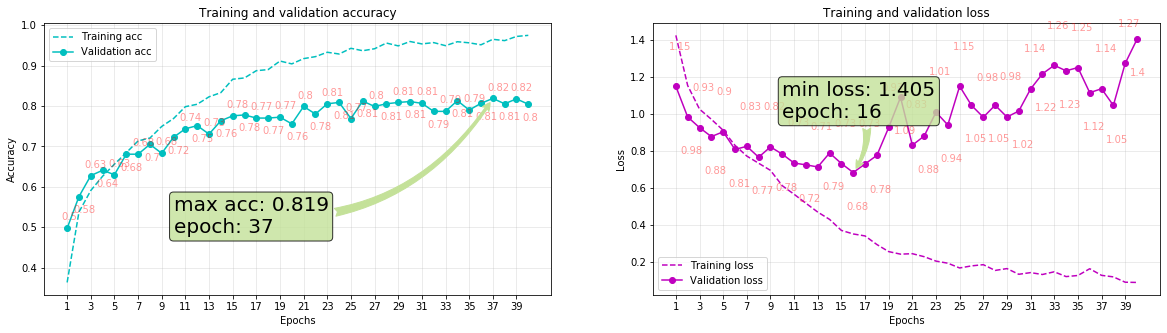

In [23]:
# show result with plot
print('model file name is:', filename)
hlp.show_model_plot(model_h);